In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from matplotlib import pyplot as plt



In [2]:
train_transform = transforms.Compose([transforms.Resize((256, 256)),
                                    transforms.RandomCrop(size=(224, 224)),
                                    transforms.RandomRotation(degrees=30),
                                    transforms.RandomHorizontalFlip(p=0.4),
                                    transforms.RandomVerticalFlip(p=0.4),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0,0,0], std=[1,1,1])
                                    ])

In [3]:
test_transform = transforms.Compose([transforms.Resize((256, 256)),
                                     transforms.CenterCrop(size=(224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0,0,0], std=[1,1,1])
                                    ])

In [4]:
train_data = datasets.Flowers102(root='.', download=True, split='train', transform=train_transform)
valid_data = datasets.Flowers102(root='.', download=True, split='val', transform=test_transform)

In [5]:
train_data[120][0].shape

torch.Size([3, 224, 224])

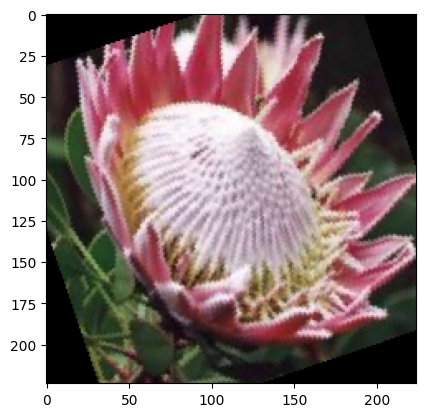

In [6]:
plt.imshow(train_data[120][0].permute(1, 2, 0))

In [7]:
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=16, shuffle=True)

In [8]:
model = models.resnet50(pretrained=True)

e:\pytorch-course\torchenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\pytorch-course\torchenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
for param in model.parameters():
    param.requires_grad = False

In [10]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
fc_in_features = model.fc.in_features

In [12]:
model.fc = nn.Linear(in_features=fc_in_features, out_features=102)

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
epochs = 100
num_valid_data = len(valid_data)
num_train_data = len(train_data)

In [16]:
for epoch in range(0, epochs):

    model.train()

    if epoch % 3 == 0:
        checkpoint = {
            'model_state' : model.state_dict(),
            'optimizer_state' : optimizer.state_dict(),
            'epoch' : epoch
        }
        torch.save(checkpoint, 'checkpoint.pth')

    correct_train = 0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        yhat = model(x)
        _, train_label = torch.max(yhat ,1)
        correct_train += (train_label == y).sum()

        optimizer.zero_grad()
        
        with torch.set_grad_enabled(True):
            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()

    train_accuracy = correct_train / num_train_data

    print(f'train_accuracy epoch{epoch}: {train_accuracy}')    

    model.eval()
    
    correct_val = 0

    for x_val, y_val in valid_loader:
        x_val = x_val.to(device)
        y_val = y_val.to(device)
       
        yhat_val = model(x_val)
        _, val_label = torch.max(yhat_val ,1)
        correct_val += (val_label == y_val).sum()

    val_accuracy = correct_val / num_valid_data
    print(f'val_accuracy epoch{epoch}: {val_accuracy}')

train_accuracy epoch0: 0.07745098322629929
val_accuracy epoch0: 0.3019607961177826
train_accuracy epoch1: 0.39411768317222595
val_accuracy epoch1: 0.4941176772117615
train_accuracy epoch2: 0.615686297416687
val_accuracy epoch2: 0.5980392694473267
train_accuracy epoch3: 0.7323529720306396
val_accuracy epoch3: 0.6392157077789307
train_accuracy epoch4: 0.7892157435417175
val_accuracy epoch4: 0.6950981020927429
train_accuracy epoch5: 0.8284314274787903
val_accuracy epoch5: 0.7274510264396667
train_accuracy epoch6: 0.8558824062347412
val_accuracy epoch6: 0.7431373000144958
train_accuracy epoch7: 0.8607843518257141
val_accuracy epoch7: 0.7392157316207886
train_accuracy epoch8: 0.9000000357627869
val_accuracy epoch8: 0.7509804368019104
train_accuracy epoch9: 0.8862745761871338
val_accuracy epoch9: 0.7500000596046448
train_accuracy epoch10: 0.9205883145332336
val_accuracy epoch10: 0.7627451419830322
train_accuracy epoch11: 0.9205883145332336
val_accuracy epoch11: 0.774509847164154
train_accura